# Cas Ménisque #2

In [1]:
#maxime
#même notebook que pour KNN mais utlisation de la Régression Logistique dans la Pipeline
import os
import pandas as pd
import numpy as np


#visualiation
import matplotlib.pyplot as plt
import seaborn as sns


#machine learning
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer

from imblearn.over_sampling import SMOTENC

#sauvegarde du modèle
import pickle


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  de

# Préparation des données

In [2]:
#données nettoyées à partir du fichier de David, et reimportées
current_dir = os.getcwd()
data = pd.read_excel(current_dir + '/data/clean_patients.xlsx')

In [3]:
data.head()

,index,patient,reprise,age,int_ext,delay,ACL,height,poids,BH,BHI
0,0,1,0,17,0,30,1,180,70,0,0
1,1,2,0,17,1,30,1,180,70,0,0
2,2,3,0,35,1,14,1,177,60,0,0
3,3,4,0,24,0,30,1,174,75,1,0
4,4,5,1,16,0,270,0,169,60,0,0


# Data Exploration

Recovery

reprise = 1 :  38
reprise = 0 :  65


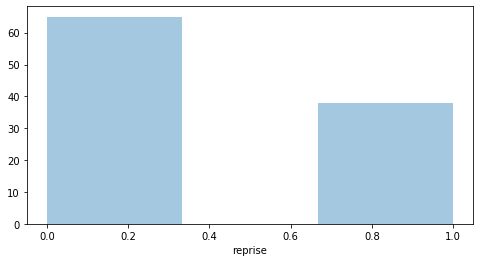

In [4]:
plt.figure(figsize=(8,4))
sns.distplot(data['reprise'], kde = False)


print('reprise = 1 : ', sum(data['reprise'] == 1) ) 
print('reprise = 0 : ', sum(data['reprise'] == 0) ) 

Age

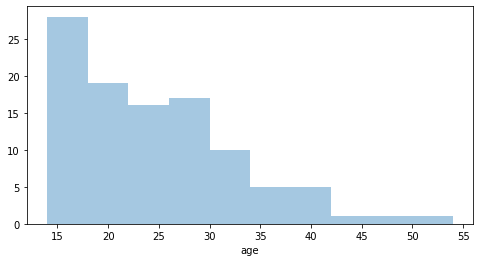

In [5]:
plt.figure(figsize=(8,4))
sns.distplot(data['age'], bins = 10, kde = False)

Après log transformation

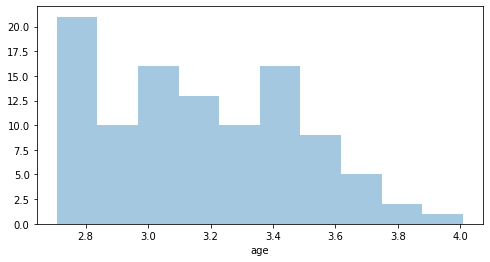

In [6]:
plt.figure(figsize=(8,4))
sns.distplot(np.log1p(data['age']), bins = 10, kde = False)

Int_ext

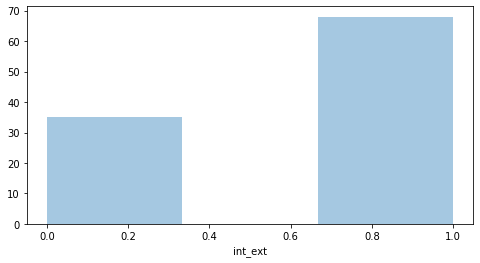

In [7]:
plt.figure(figsize=(8,4))
sns.distplot(data['int_ext'], kde = False)

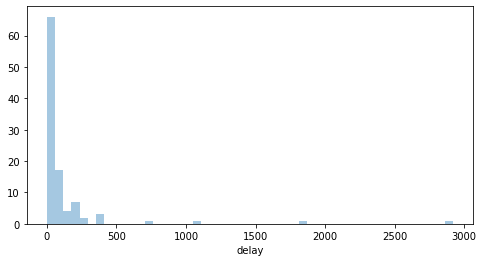

In [8]:
plt.figure(figsize=(8,4))
sns.distplot(data['delay'], kde = False)

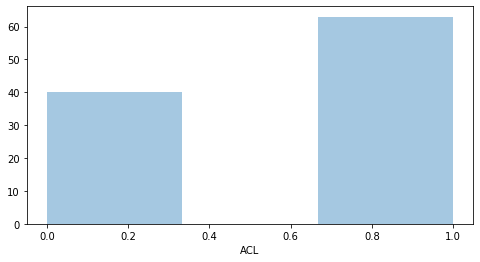

In [9]:
plt.figure(figsize=(8,4))
sns.distplot(data['ACL'], kde = False)

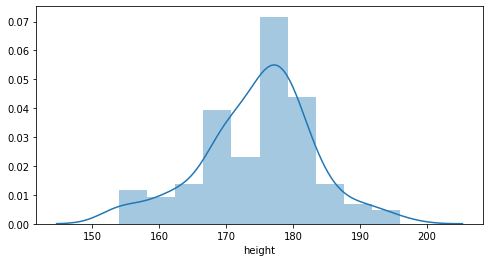

In [10]:
plt.figure(figsize=(8,4))
sns.distplot(data['height'])

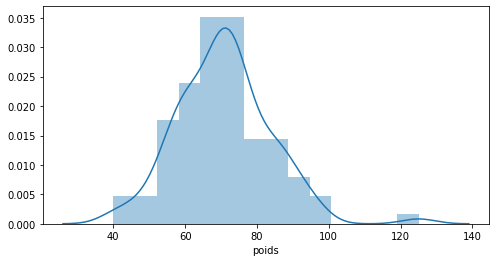

In [11]:
plt.figure(figsize=(8,4))
sns.distplot(data['poids'])

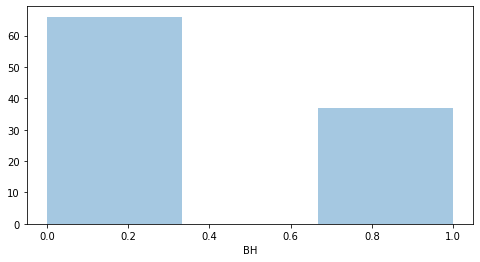

In [12]:
plt.figure(figsize=(8,4))
sns.distplot(data['BH'], kde = False)

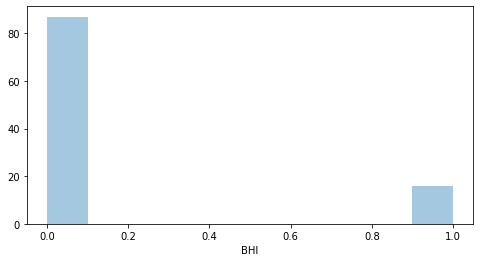

In [13]:
plt.figure(figsize=(8,4))
sns.distplot(data['BHI'], kde = False)

# Gestion des outliers : Discrétisation - log_transformation

Pour la feature delay

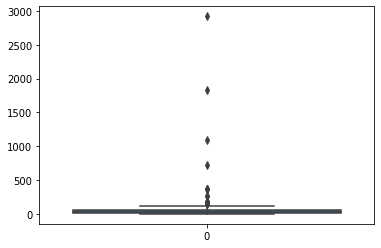

In [14]:
sns.boxplot(data=data['delay'])

On observe de nombreux outliers grâce à cette boîte à moustache (points en noir). Nous ferons une log transformation par la suite

# Feature Engineering

Poids _ taille --> IMC

In [15]:
data['IMC'] = data['poids'] / (data['height'] /100)**2

In [16]:
data.head()

,index,patient,reprise,age,int_ext,delay,ACL,height,poids,BH,BHI,IMC
0,0,1,0,17,0,30,1,180,70,0,0,21.604938
1,1,2,0,17,1,30,1,180,70,0,0,21.604938
2,2,3,0,35,1,14,1,177,60,0,0,19.151585
3,3,4,0,24,0,30,1,174,75,1,0,24.772097
4,4,5,1,16,0,270,0,169,60,0,0,21.007668


Anse de Sceau, combinaison BH et BHI

In [17]:
data['new_BH'] = data['BH'] + data['BHI'] 
data['new_BH'] = data['new_BH'].astype(int)

# Data Augmentation

In [18]:
smote = SMOTENC(sampling_strategy='minority', 
                categorical_features = [True, True, False, True, False, True, False, True, True, True],
                random_state = 1, n_jobs=-1)

In [19]:
features = ['index', 'patient', 'age', 'int_ext', 'delay', 'ACL', 'IMC', 'BH', 'BHI', 'new_BH']
target = ['reprise']

In [20]:
X_sm, y_sm = smote.fit_resample(data[features], data[target])

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
XX = pd.DataFrame(data = X_sm, columns = features)
YY = pd.DataFrame(data = y_sm, columns = target)

In [22]:
XX

,index,patient,age,int_ext,delay,ACL,IMC,BH,BHI,new_BH
0,0.0,1.0,17.000000,0.0,30.000000,1.0,21.604938,0.0,0.0,0.0
1,1.0,2.0,17.000000,1.0,30.000000,1.0,21.604938,0.0,0.0,0.0
2,2.0,3.0,35.000000,1.0,14.000000,1.0,19.151585,0.0,0.0,0.0
3,3.0,4.0,24.000000,0.0,30.000000,1.0,24.772097,1.0,0.0,1.0
4,4.0,5.0,16.000000,0.0,270.000000,0.0,21.007668,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
125,81.0,98.0,15.366821,1.0,180.000000,0.0,21.924826,1.0,0.0,0.0
126,58.0,86.0,22.184569,1.0,365.000000,0.0,21.810004,0.0,0.0,0.0
127,99.0,101.0,31.230622,1.0,60.000000,0.0,22.484023,1.0,0.0,1.0
128,89.0,95.0,23.642707,1.0,13.323591,1.0,25.043640,1.0,0.0,0.0


In [23]:
print((YY ==0).sum())
print((YY ==1).sum())

print(YY.shape[0])

reprise    65
dtype: int64
reprise    65
dtype: int64
130


In [24]:
#dataframe augmenté
data = pd.concat([XX, YY], axis = 1)

In [25]:
data.head()

,index,patient,age,int_ext,delay,ACL,IMC,BH,BHI,new_BH,reprise
0,0.0,1.0,17.0,0.0,30.0,1.0,21.604938,0.0,0.0,0.0,0
1,1.0,2.0,17.0,1.0,30.0,1.0,21.604938,0.0,0.0,0.0,0
2,2.0,3.0,35.0,1.0,14.0,1.0,19.151585,0.0,0.0,0.0,0
3,3.0,4.0,24.0,0.0,30.0,1.0,24.772097,1.0,0.0,1.0,0
4,4.0,5.0,16.0,0.0,270.0,0.0,21.007668,0.0,0.0,0.0,1


# Partie Machine_Learning

# Pre_process pipeline

feature quanti

In [26]:
quanti_feature = ['IMC']

In [27]:
transfo_quanti = Pipeline(steps = [
    ('normalisation', StandardScaler()) #MinMaxScaler() moins bon
])

In [28]:
quanti_feature_log = ['age']

In [29]:
transfo_quanti_log = Pipeline(steps = [
    ('log', FunctionTransformer(np.log1p)), #log transformation 
    ('normalisation', StandardScaler())
])

feature catégorie

In [30]:
categorical_feature = ['int_ext','ACL', 'new_BH']

In [31]:
transfo_categorical = Pipeline(steps = [
    ('one_hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))
])

feature catégorie_ordinal

In [32]:
ord_feature = ['delay']

In [33]:
transfo_ord_disc = Pipeline(steps = [
    ('discretisation', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')) #discrétisation
])

pre_process_pipeline

In [34]:
pre_process = ColumnTransformer(
    transformers = [
        ('quanti', transfo_quanti, quanti_feature),
        ('categorical', transfo_categorical, categorical_feature),
        ('ord', transfo_ord_disc, ord_feature), 
        ('quanti_log', transfo_quanti_log, quanti_feature_log)
    ])

# machine learning pipeline

In [35]:
model = Pipeline(steps = [('pre_process', pre_process), 
                           ('rlog', LogisticRegression()) ])

In [36]:
#param_grid selon le modèle
#knn
param_grid_knn = [
                {
    'knn__n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12, 13, 14, 15],
    }]

#Paramètres pour autres modèles
#Régréssion Log
param_grid_log = [
                {
    'rlog__solver' : ['liblinear', 'newton-cg', 'lbfgs'],
    'rlog__penalty' : ['l2'], #tenter une l1
    'rlog__C' : [0.01, 0.1, 0.5, 1.0, 10, 50, 100]
}, 
                {
    'rlog__solver' : ['liblinear', 'newton-cg', 'lbfgs'],
    'rlog__C' : [0.01, 0.1, 0.5, 1.0, 10, 50, 100]
},
                {
    'rlog__solver' : ['liblinear'],
    'rlog__penalty' : ['l1'], #tenter une l1
    'rlog__C' : [0.01, 0.1, 0.5, 1.0, 10, 50, 100]
},
                {
    'rlog__solver' : ['saga'],
    'rlog__penalty' : ['elasticnet'], #tenter une l1
    'rlog__C' : [0.01, 0.1, 0.5, 1.0, 10, 50, 100],
    'rlog__l1_ratio' : [0.2, 0.5, 0.7]
    }]

#GradientBoostingClassifier

param_grid_gb = [
                {
    'gb__n_estimators' : [10, 50, 100, 150],
    'gb__min_samples_split'  : [2, 4, 7, 10]
    }]

param_grid_svc = [
                {
    'svc__kernel' : ['linear', 'sigmoid'],
    'svc__C' : [0.01, 0.1, 1, 5, 10, 50]
    }]


scores = ['roc_auc', 'accuracy', 'recall', 'f1'] # 'f1', 'accuracy'

In [37]:
print('Hyperparamètres testés')
param_grid_log

Hyperparamètres testés


[{'rlog__solver': ['liblinear', 'newton-cg', 'lbfgs'],
  'rlog__penalty': ['l2'],
  'rlog__C': [0.01, 0.1, 0.5, 1.0, 10, 50, 100]},
 {'rlog__solver': ['liblinear', 'newton-cg', 'lbfgs'],
  'rlog__C': [0.01, 0.1, 0.5, 1.0, 10, 50, 100]},
 {'rlog__solver': ['liblinear'],
  'rlog__penalty': ['l1'],
  'rlog__C': [0.01, 0.1, 0.5, 1.0, 10, 50, 100]},
 {'rlog__solver': ['saga'],
  'rlog__penalty': ['elasticnet'],
  'rlog__C': [0.01, 0.1, 0.5, 1.0, 10, 50, 100],
  'rlog__l1_ratio': [0.2, 0.5, 0.7]}]

In [38]:
grid_search = GridSearchCV(estimator = model, param_grid = param_grid_log, cv = 7,
                           n_jobs = -1, scoring = scores, verbose = 1, refit = False,
                           return_train_score = True, error_score = 'raise') #cv 3, 5, 10, pas bcp de données..

FEATURES CONSERVEES POUR LA CONSTRUCTION DU MODELE

In [39]:
features = ['age','int_ext', 'delay', 'ACL', 'IMC', 'new_BH']
x = data[features]

In [40]:
y = data['reprise']

In [41]:
x.head()

,age,int_ext,delay,ACL,IMC,new_BH
0,17.0,0.0,30.0,1.0,21.604938,0.0
1,17.0,1.0,30.0,1.0,21.604938,0.0
2,35.0,1.0,14.0,1.0,19.151585,0.0
3,24.0,0.0,30.0,1.0,24.772097,1.0
4,16.0,0.0,270.0,0.0,21.007668,0.0


A la rechercher des meilleurs paramètres...

In [42]:
grid_search.fit(x, y)

Fitting 7 folds for each of 70 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:   23.4s finished


GridSearchCV(cv=7, error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('quanti',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('normalisation',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                           

In [43]:
#df résumant les résultats (scores, score pour chaque split)
dic_results = grid_search.cv_results_
df_results = pd.DataFrame(data = dic_results).sort_values(by = ['rank_test_f1', 'rank_test_accuracy', 
                                                                'rank_test_roc_auc'])
df_results = df_results.iloc[:,8:]

In [44]:
df_results

,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,split5_test_roc_auc,split6_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,...,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,mean_train_f1,std_train_f1
1,"{'rlog__C': 0.01, 'rlog__penalty': 'l2', 'rlog...",0.600000,0.944444,0.844444,0.633333,0.901235,0.679012,0.851852,0.779189,0.128263,...,1,0.761062,0.713043,0.722222,0.733945,0.709091,0.752294,0.714286,0.729420,0.018925
2,"{'rlog__C': 0.01, 'rlog__penalty': 'l2', 'rlog...",0.600000,0.944444,0.844444,0.633333,0.901235,0.679012,0.851852,0.779189,0.128263,...,1,0.761062,0.713043,0.722222,0.733945,0.709091,0.752294,0.714286,0.729420,0.018925
22,"{'rlog__C': 0.01, 'rlog__solver': 'newton-cg'}",0.600000,0.944444,0.844444,0.633333,0.901235,0.679012,0.851852,0.779189,0.128263,...,1,0.761062,0.713043,0.722222,0.733945,0.709091,0.752294,0.714286,0.729420,0.018925
23,"{'rlog__C': 0.01, 'rlog__solver': 'lbfgs'}",0.600000,0.944444,0.844444,0.633333,0.901235,0.679012,0.851852,0.779189,0.128263,...,1,0.761062,0.713043,0.722222,0.733945,0.709091,0.752294,0.714286,0.729420,0.018925
0,"{'rlog__C': 0.01, 'rlog__penalty': 'l2', 'rlog...",0.611111,0.922222,0.822222,0.677778,0.962963,0.666667,0.839506,0.786067,0.125690,...,5,0.781955,0.730159,0.747967,0.734375,0.732824,0.744186,0.765625,0.748156,0.017777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,"{'rlog__C': 0.01, 'rlog__l1_ratio': 0.2, 'rlog...",0.600000,0.894444,0.811111,0.450000,0.839506,0.672840,0.814815,0.726102,0.147002,...,66,0.698413,0.661417,0.666667,0.720000,0.653846,0.699029,0.679612,0.682712,0.022223
43,"{'rlog__C': 0.1, 'rlog__penalty': 'l1', 'rlog_...",0.611111,0.900000,0.833333,0.516667,0.839506,0.567901,0.851852,0.731481,0.147514,...,67,0.713287,0.685315,0.723404,0.688000,0.705882,0.738462,0.666667,0.703002,0.022822
50,"{'rlog__C': 0.01, 'rlog__l1_ratio': 0.5, 'rlog...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,...,68,0.670659,0.670659,0.000000,0.000000,0.666667,0.000000,0.000000,0.286855,0.331234
51,"{'rlog__C': 0.01, 'rlog__l1_ratio': 0.7, 'rlog...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,...,69,0.670659,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.191046,0.302073


# Analyse Overfiiting

In [45]:
print('{} modèles analysés'.format(df_results.shape[0]))
print('Modèles triés par ordre f1, accuracy, roc_auc - dans l\'ordre décroissant')

70 modèles analysés
Modèles triés par ordre f1, accuracy, roc_auc - dans l'ordre décroissant


In [46]:
df_scores_train_test = df_results[['mean_test_roc_auc', 'mean_train_roc_auc', 'rank_test_roc_auc',
                                   'mean_test_f1', 'mean_train_f1', 'rank_test_f1', 
                                   'mean_test_accuracy', 'mean_train_accuracy', 'rank_test_accuracy']]
df_scores_train_test.head()

,mean_test_roc_auc,mean_train_roc_auc,rank_test_roc_auc,mean_test_f1,mean_train_f1,rank_test_f1,mean_test_accuracy,mean_train_accuracy,rank_test_accuracy
1,0.779189,0.803690,52,0.728657,0.729420,1,0.724311,0.730775,35
2,0.779189,0.803690,52,0.728657,0.729420,1,0.724311,0.730775,35
22,0.779189,0.803690,52,0.728657,0.729420,1,0.724311,0.730775,35
23,0.779189,0.803690,52,0.728657,0.729420,1,0.724311,0.730775,35
0,0.786067,0.811688,49,0.728463,0.748156,5,0.685881,0.710264,64


In [47]:
print('Meilleurs modèles')

test_scores = df_results[['mean_test_roc_auc', 'rank_test_roc_auc', 'mean_test_f1', 'rank_test_f1',
                         'mean_test_accuracy', 'rank_test_accuracy']]
test_scores['train/test'] = 'test'
test_scores = test_scores.rename(columns = {'mean_test_roc_auc' : 'score_roc_auc', 'mean_test_f1' : 'score_f1',
                                           'mean_test_accuracy' : 'score_accuracy'})

train_scores = df_results[['mean_train_roc_auc', 'rank_test_roc_auc', 'mean_train_f1', 'rank_test_f1',
                          'mean_train_accuracy', 'rank_test_accuracy']]
train_scores['train/test'] = 'train'
train_scores = train_scores.rename(columns = {'mean_train_roc_auc' : 'score_roc_auc', 'mean_train_f1' : 'score_f1',
                                             'mean_train_accuracy' : 'score_accuracy'})

test_train_scores = pd.concat([test_scores, train_scores], axis = 0)
test_train_scores['modele'] = test_train_scores.index
test_train_scores.head()

Meilleurs modèles


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,score_roc_auc,rank_test_roc_auc,score_f1,rank_test_f1,score_accuracy,rank_test_accuracy,train/test,modele
1,0.779189,52,0.728657,1,0.724311,35,test,1
2,0.779189,52,0.728657,1,0.724311,35,test,2
22,0.779189,52,0.728657,1,0.724311,35,test,22
23,0.779189,52,0.728657,1,0.724311,35,test,23
0,0.786067,49,0.728463,5,0.685881,64,test,0


Graphs pour analyser le sur-apprentissage entre chaque modèle, pour chaque metrique (accuracy, f1, AUC)

(0.2, 1)

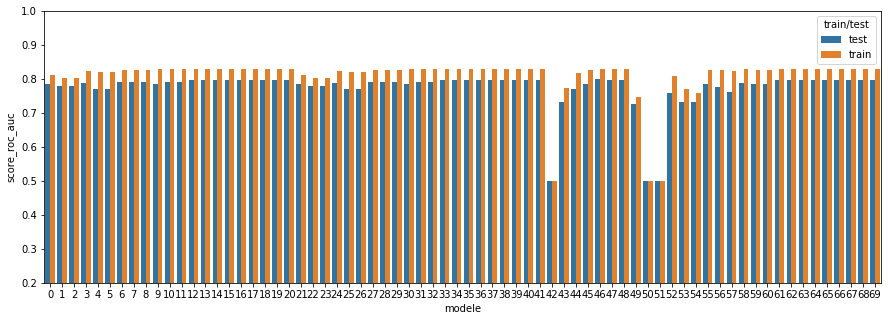

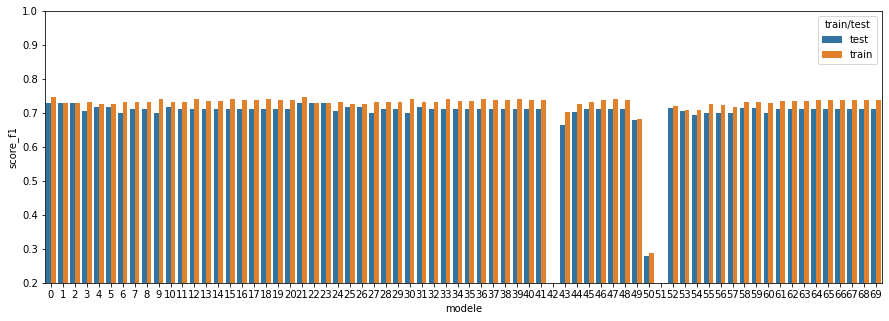

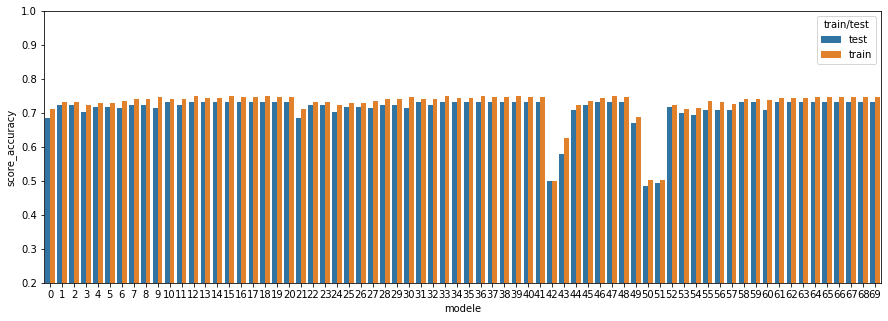

In [48]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='modele', y="score_roc_auc", hue="train/test", data=test_train_scores)
plt.ylim(0.2,1)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='modele', y="score_f1", hue="train/test", data=test_train_scores)
plt.ylim(0.2,1)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='modele', y="score_accuracy", hue="train/test", data=test_train_scores)
plt.ylim(0.2,1)

# Courbe d'apprentissage sur modèle de son choix

Choisir le modèle à analyser plus précisément ci-dessous

In [53]:
#modèle choisi à analyser plus précisément, en
num_modele = 1

In [54]:
params = pd.DataFrame(data = dic_results)['params'][num_modele]

In [55]:
print('Paramètres utilisés dans le modèle')
params

Paramètres utilisés dans le modèle


{'rlog__C': 0.01, 'rlog__penalty': 'l2', 'rlog__solver': 'newton-cg'}

In [56]:
my_model = Pipeline(steps = [('pre_process', pre_process), 
                               ('rlog',LogisticRegression(C= params['rlog__C'],
                                                         solver= params['rlog__solver'],
                                                         penalty= params['rlog__penalty']) ) ])

In [57]:
train_sizes = [20, 30, 50, 60, 80]
train_sizes, train_scores, validation_scores = learning_curve(
                                                estimator = my_model, X = x,
                                                y = y, train_sizes = train_sizes, cv = 7,
                                                scoring = 'accuracy', shuffle = True, n_jobs = -1,
                                                verbose = 1, random_state = 1
                                                )

[learning_curve] Training set sizes: [20 30 50 60 80]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished


In [58]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

print('Moyenne accuracy entrainement de tous les folds\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('Moyenne accuracy test de tous les folds\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Moyenne accuracy entrainement de tous les folds

 20    0.642857
30    0.695238
50    0.677143
60    0.702381
80    0.710714
dtype: float64

 --------------------
Moyenne accuracy test de tous les folds

 20    0.555556
30    0.602757
50    0.654553
60    0.670844
80    0.677945
dtype: float64


(0.3, 1)

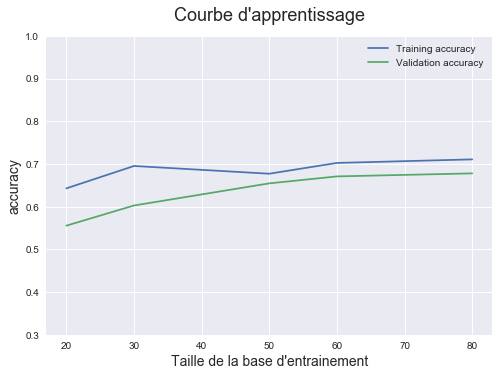

In [59]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy')

plt.ylabel('accuracy', fontsize=14)
plt.xlabel('Taille de la base d\'entrainement', fontsize=14)
plt.title("Courbe d'apprentissage", fontsize=18, y=1.03)
plt.legend()
plt.ylim(0.3,1)

# Entrainement et Sauvegarde du modèle final

my_model créé avant la courbe d'apprentissage (pre_processing inclu)

In [60]:
my_model.fit(x, y)

Pipeline(memory=None,
         steps=[('pre_process',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('quanti',
                                                  Pipeline(memory=None,
                                                           steps=[('normalisation',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['IMC']),
                                                 ('categorical',
                                                  Pipel

In [61]:
pickle.dump(my_model, open(current_dir + '/reg_log_model.pkl','wb'))

# Importance des features

In [62]:
perm = PermutationImportance(my_model, random_state=1).fit(x, y)
eli5.show_weights(perm, feature_names = ['age', 'int_ext', 'delay', 'ACL', 'IMC', 'new_BH'])

Weight,Feature
0.1708 ± 0.0611,delay
0.0077 ± 0.0257,IMC
0.0046 ± 0.0345,ACL
0.0031 ± 0.0185,age
-0.0077 ± 0.0097,new_BH
-0.0092 ± 0.0062,int_ext


Délais est la feature qui a le plus de poids, ce qui semble apriori logique. Etrangement, l'IMC a peu d'influence